**Group Members:**

* Chandana Vangapalli (ID: 233323)
* Yizhou Yu (ID: 236819)
* Akpany Aubin Benjamin Ebby (ID: 232836 )
* Bangyi Wu (ID: 183398)


**Objective:**

The primary objective of our project is to apply sentiment analysis to the US airline industry twitter data to understand the trends in customer perceptions about some of the biggest airline companies in the USA. Further, we will also investigate what factors drive positive and negative sentiments and how this would impact the overall industry.  


**Data:**

We will use airline industry tweets for our analysis. Alternatively, we may use twitter datasets sourced from Kaggle.


In [1]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools

import numpy
import pandas as pd

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.tree import *

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from collections import Counter

In [3]:
%%R
library(dplyr)
library(reticulate)
library(ggplot2)
library(rtweet)

# U.S. Airline Twitter

**Load the Data**

In [4]:
nltk.download("stopwords") # Load StopWords
from nltk.corpus import stopwords
set(stopwords.words('english'))

tweets_dataset = pd.read_csv("data/US_Airline_Tweets.csv") # Load Data

# %Rpush tweets_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiefkemist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
tweets_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [6]:
tweets_dataset.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
tweets_dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
%%R

tweets_df <- read.csv("data/US_Airline_Tweets.csv", encoding = "UTF-8", header=TRUE, stringsAsFactors=FALSE)

**Data Exploration**

_Data Columns:_

In [9]:
%%R
tweets_df %>% colnames() # Columns

 [1] "tweet_id"                     "airline_sentiment"           
 [3] "airline_sentiment_confidence" "negativereason"              
 [5] "negativereason_confidence"    "airline"                     
 [7] "airline_sentiment_gold"       "name"                        
 [9] "negativereason_gold"          "retweet_count"               
[11] "text"                         "tweet_coord"                 
[13] "tweet_created"                "tweet_location"              
[15] "user_timezone"               


_Data Dimention / Shape:_

In [10]:
%%R
tweets_df %>% dim() # Shape / Dimension

[1] 14640    15


_Data Summary:_

In [11]:
%%R
tweets_df %>% summary() # Data Summary

    tweet_id         airline_sentiment  airline_sentiment_confidence
 Min.   :5.676e+17   Length:14640       Min.   :0.3350              
 1st Qu.:5.686e+17   Class :character   1st Qu.:0.6923              
 Median :5.695e+17   Mode  :character   Median :1.0000              
 Mean   :5.692e+17                      Mean   :0.9002              
 3rd Qu.:5.699e+17                      3rd Qu.:1.0000              
 Max.   :5.703e+17                      Max.   :1.0000              
                                                                    
 negativereason     negativereason_confidence   airline         
 Length:14640       Min.   :0.000             Length:14640      
 Class :character   1st Qu.:0.361             Class :character  
 Mode  :character   Median :0.671             Mode  :character  
                    Mean   :0.638                               
                    3rd Qu.:1.000                               
                    Max.   :1.000                         

_positive, negative, and neutral tweets shapes:_

In [12]:
positive_tweets = tweets_dataset['airline_sentiment'].str.contains("positive")
negative_tweets = tweets_dataset['airline_sentiment'].str.contains("negative")
neutral_tweets = tweets_dataset['airline_sentiment'].str.contains("neutral")


print(f'positive tweets shape: {positive_tweets.shape}')
print(f'negative tweets shape: {negative_tweets.shape}')
print(f'neutral tweets shape: {neutral_tweets.shape}')

positive tweets shape: (14640,)
negative tweets shape: (14640,)
neutral tweets shape: (14640,)


In [13]:
def word_cloud(content):
    wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(content))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

## _Positive Tweets about Airlines Word Cloud:_

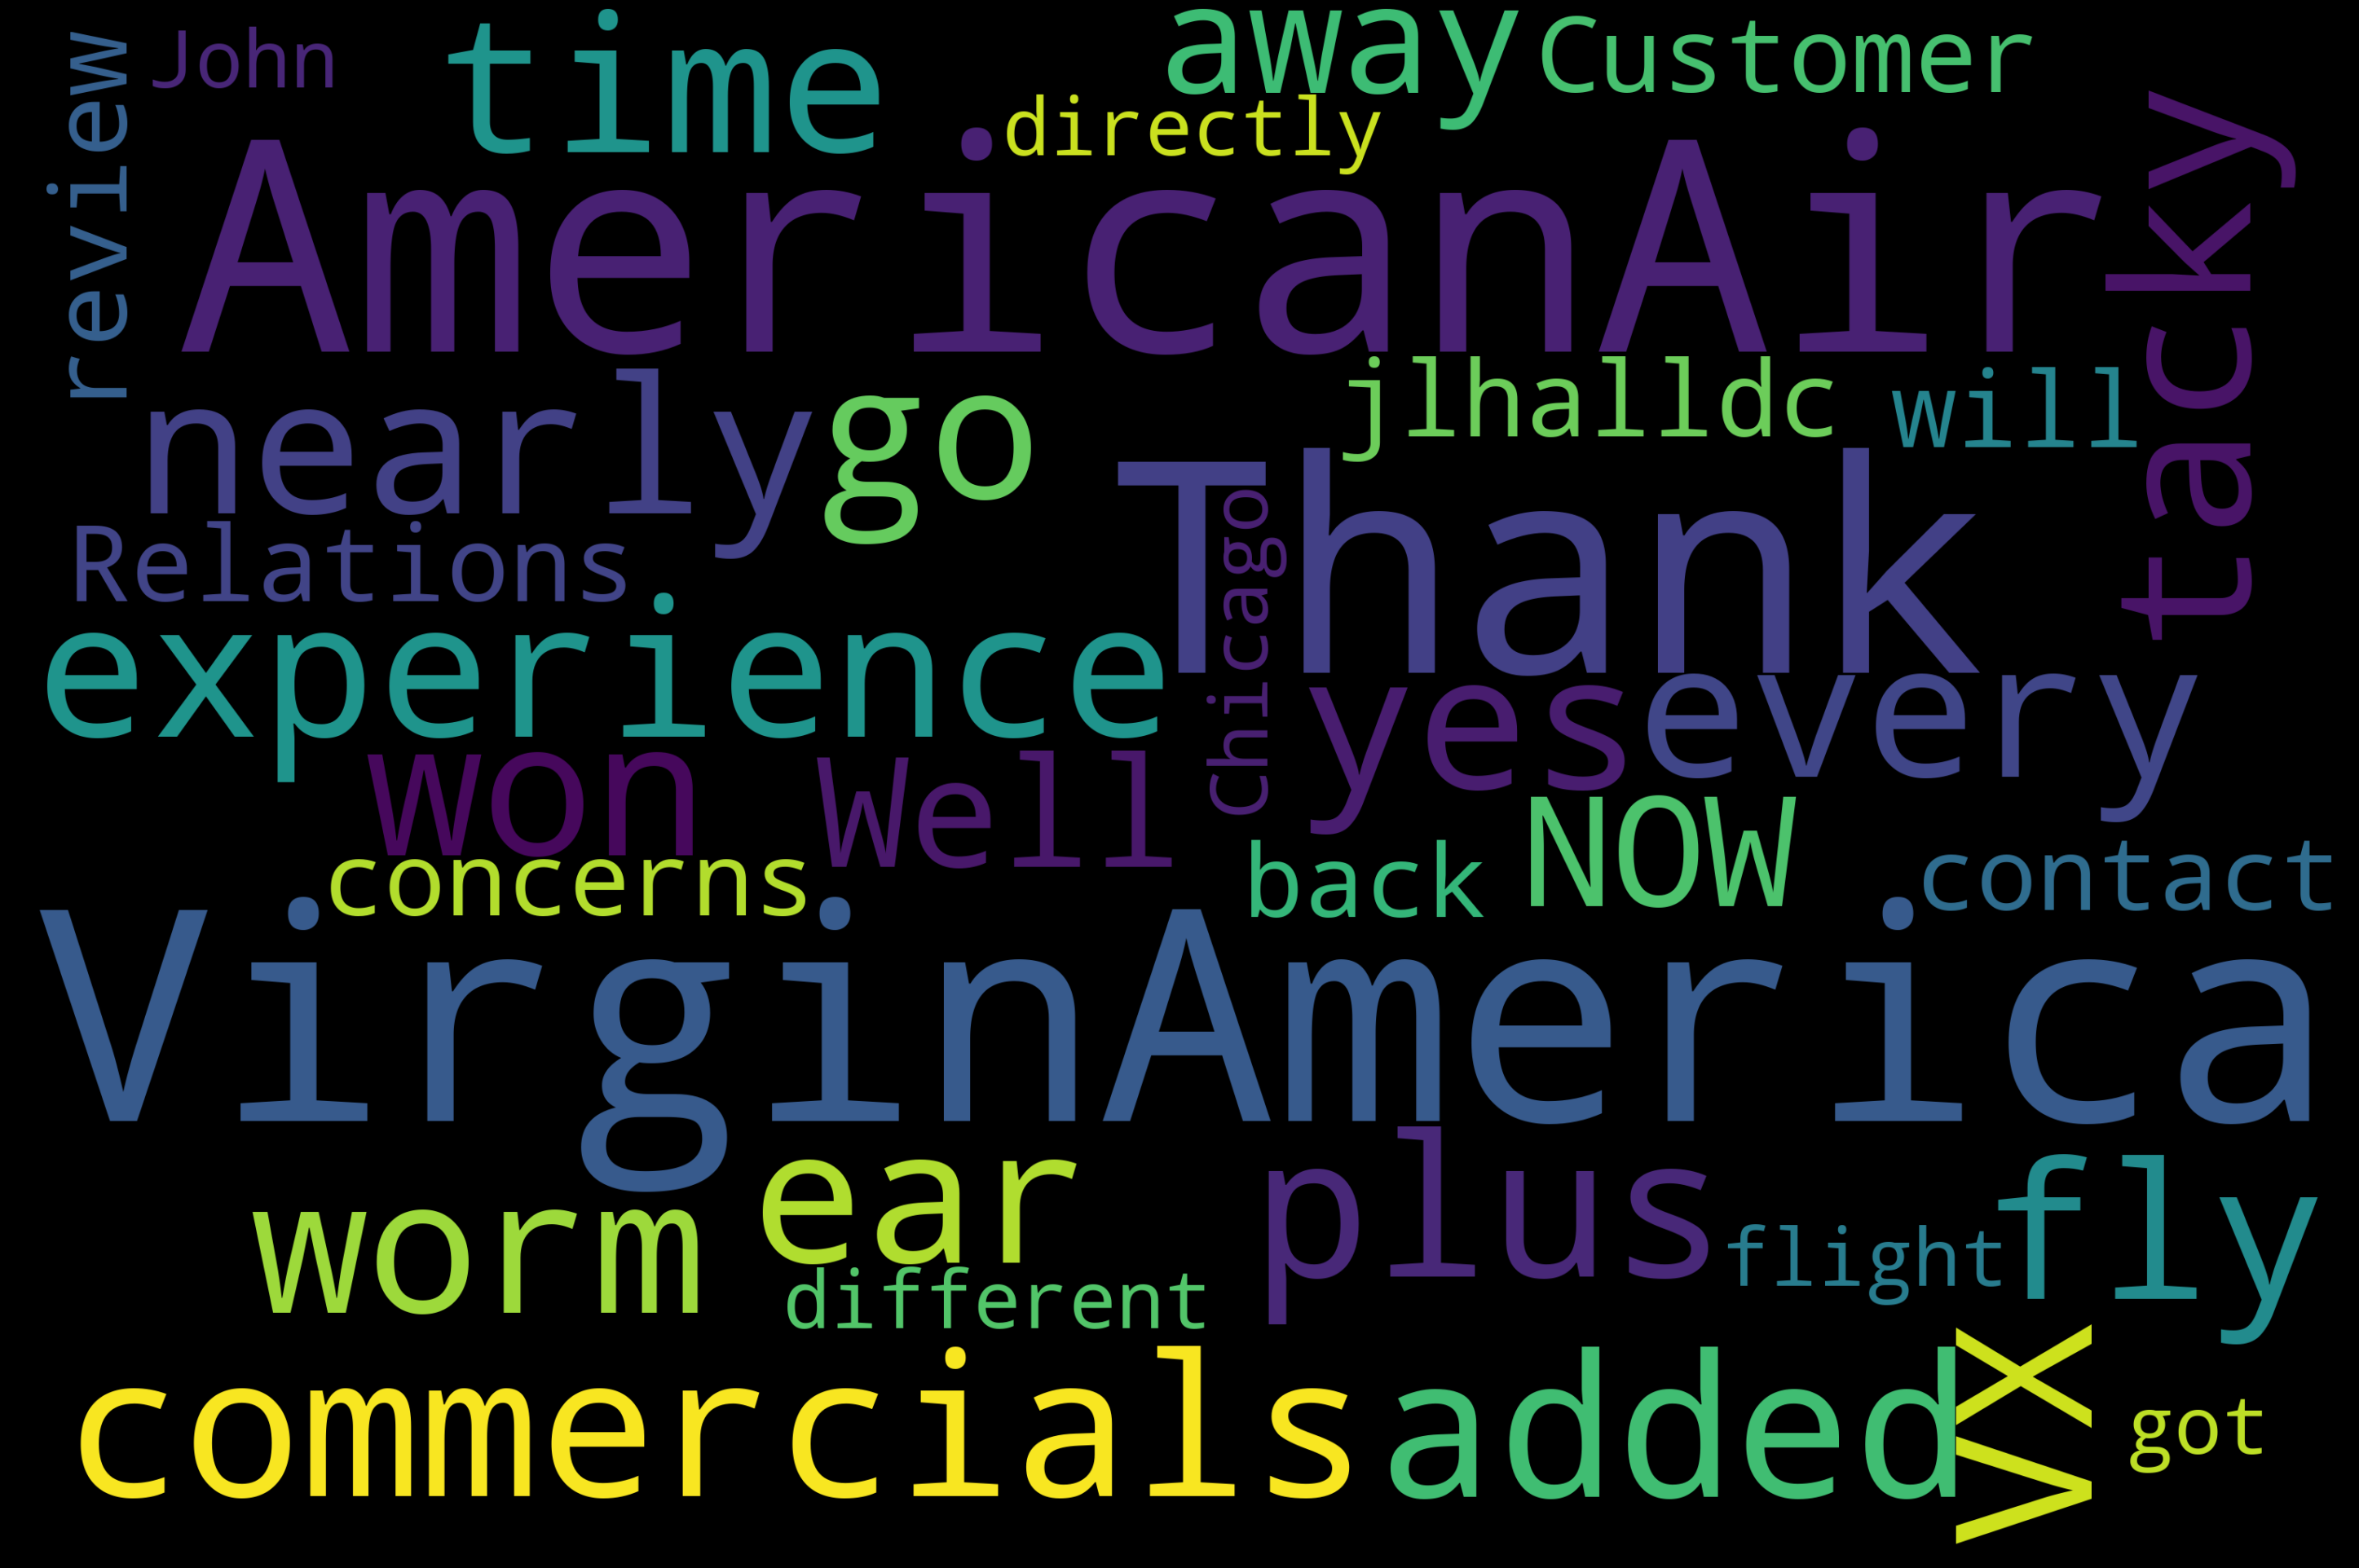

In [14]:
word_cloud(tweets_dataset.loc[tweets_dataset['airline_sentiment'] == 'positive'].text.values)

## _Neutral Tweets about Airlines Word Cloud:_

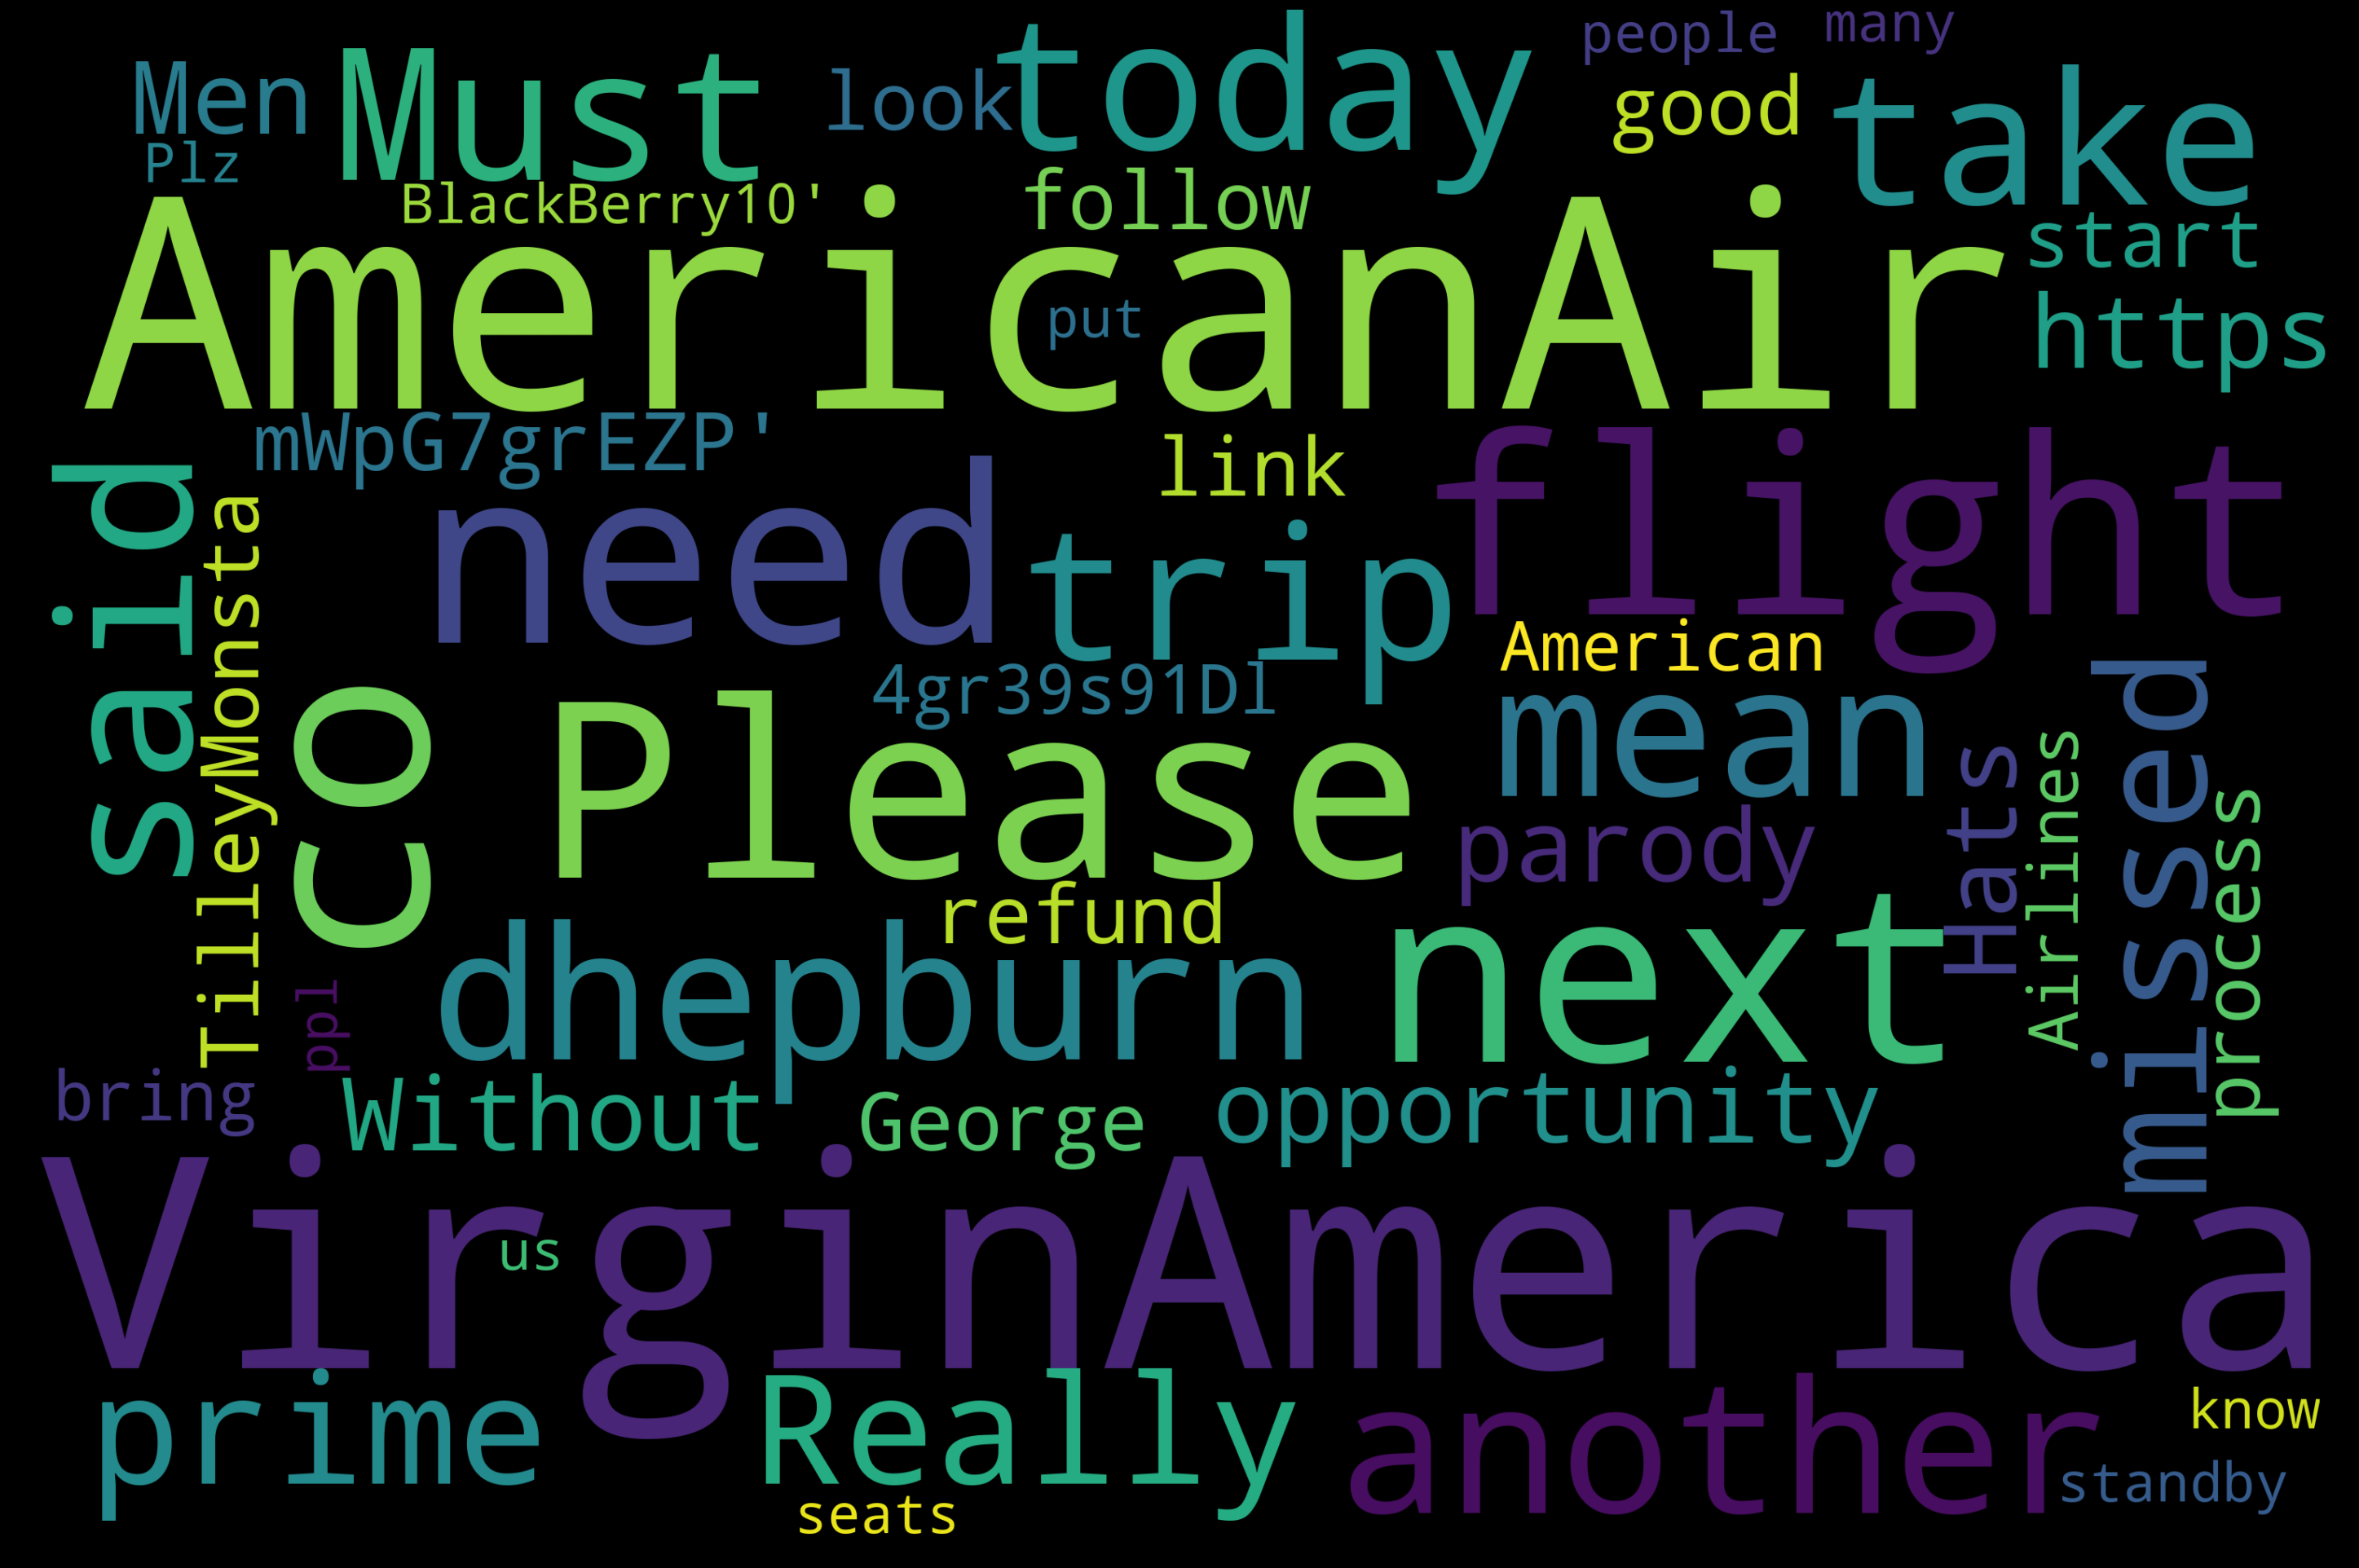

In [15]:
word_cloud(tweets_dataset.loc[tweets_dataset['airline_sentiment'] == 'neutral'].text.values)

## _Negative Tweets about Airlines Word Cloud:_

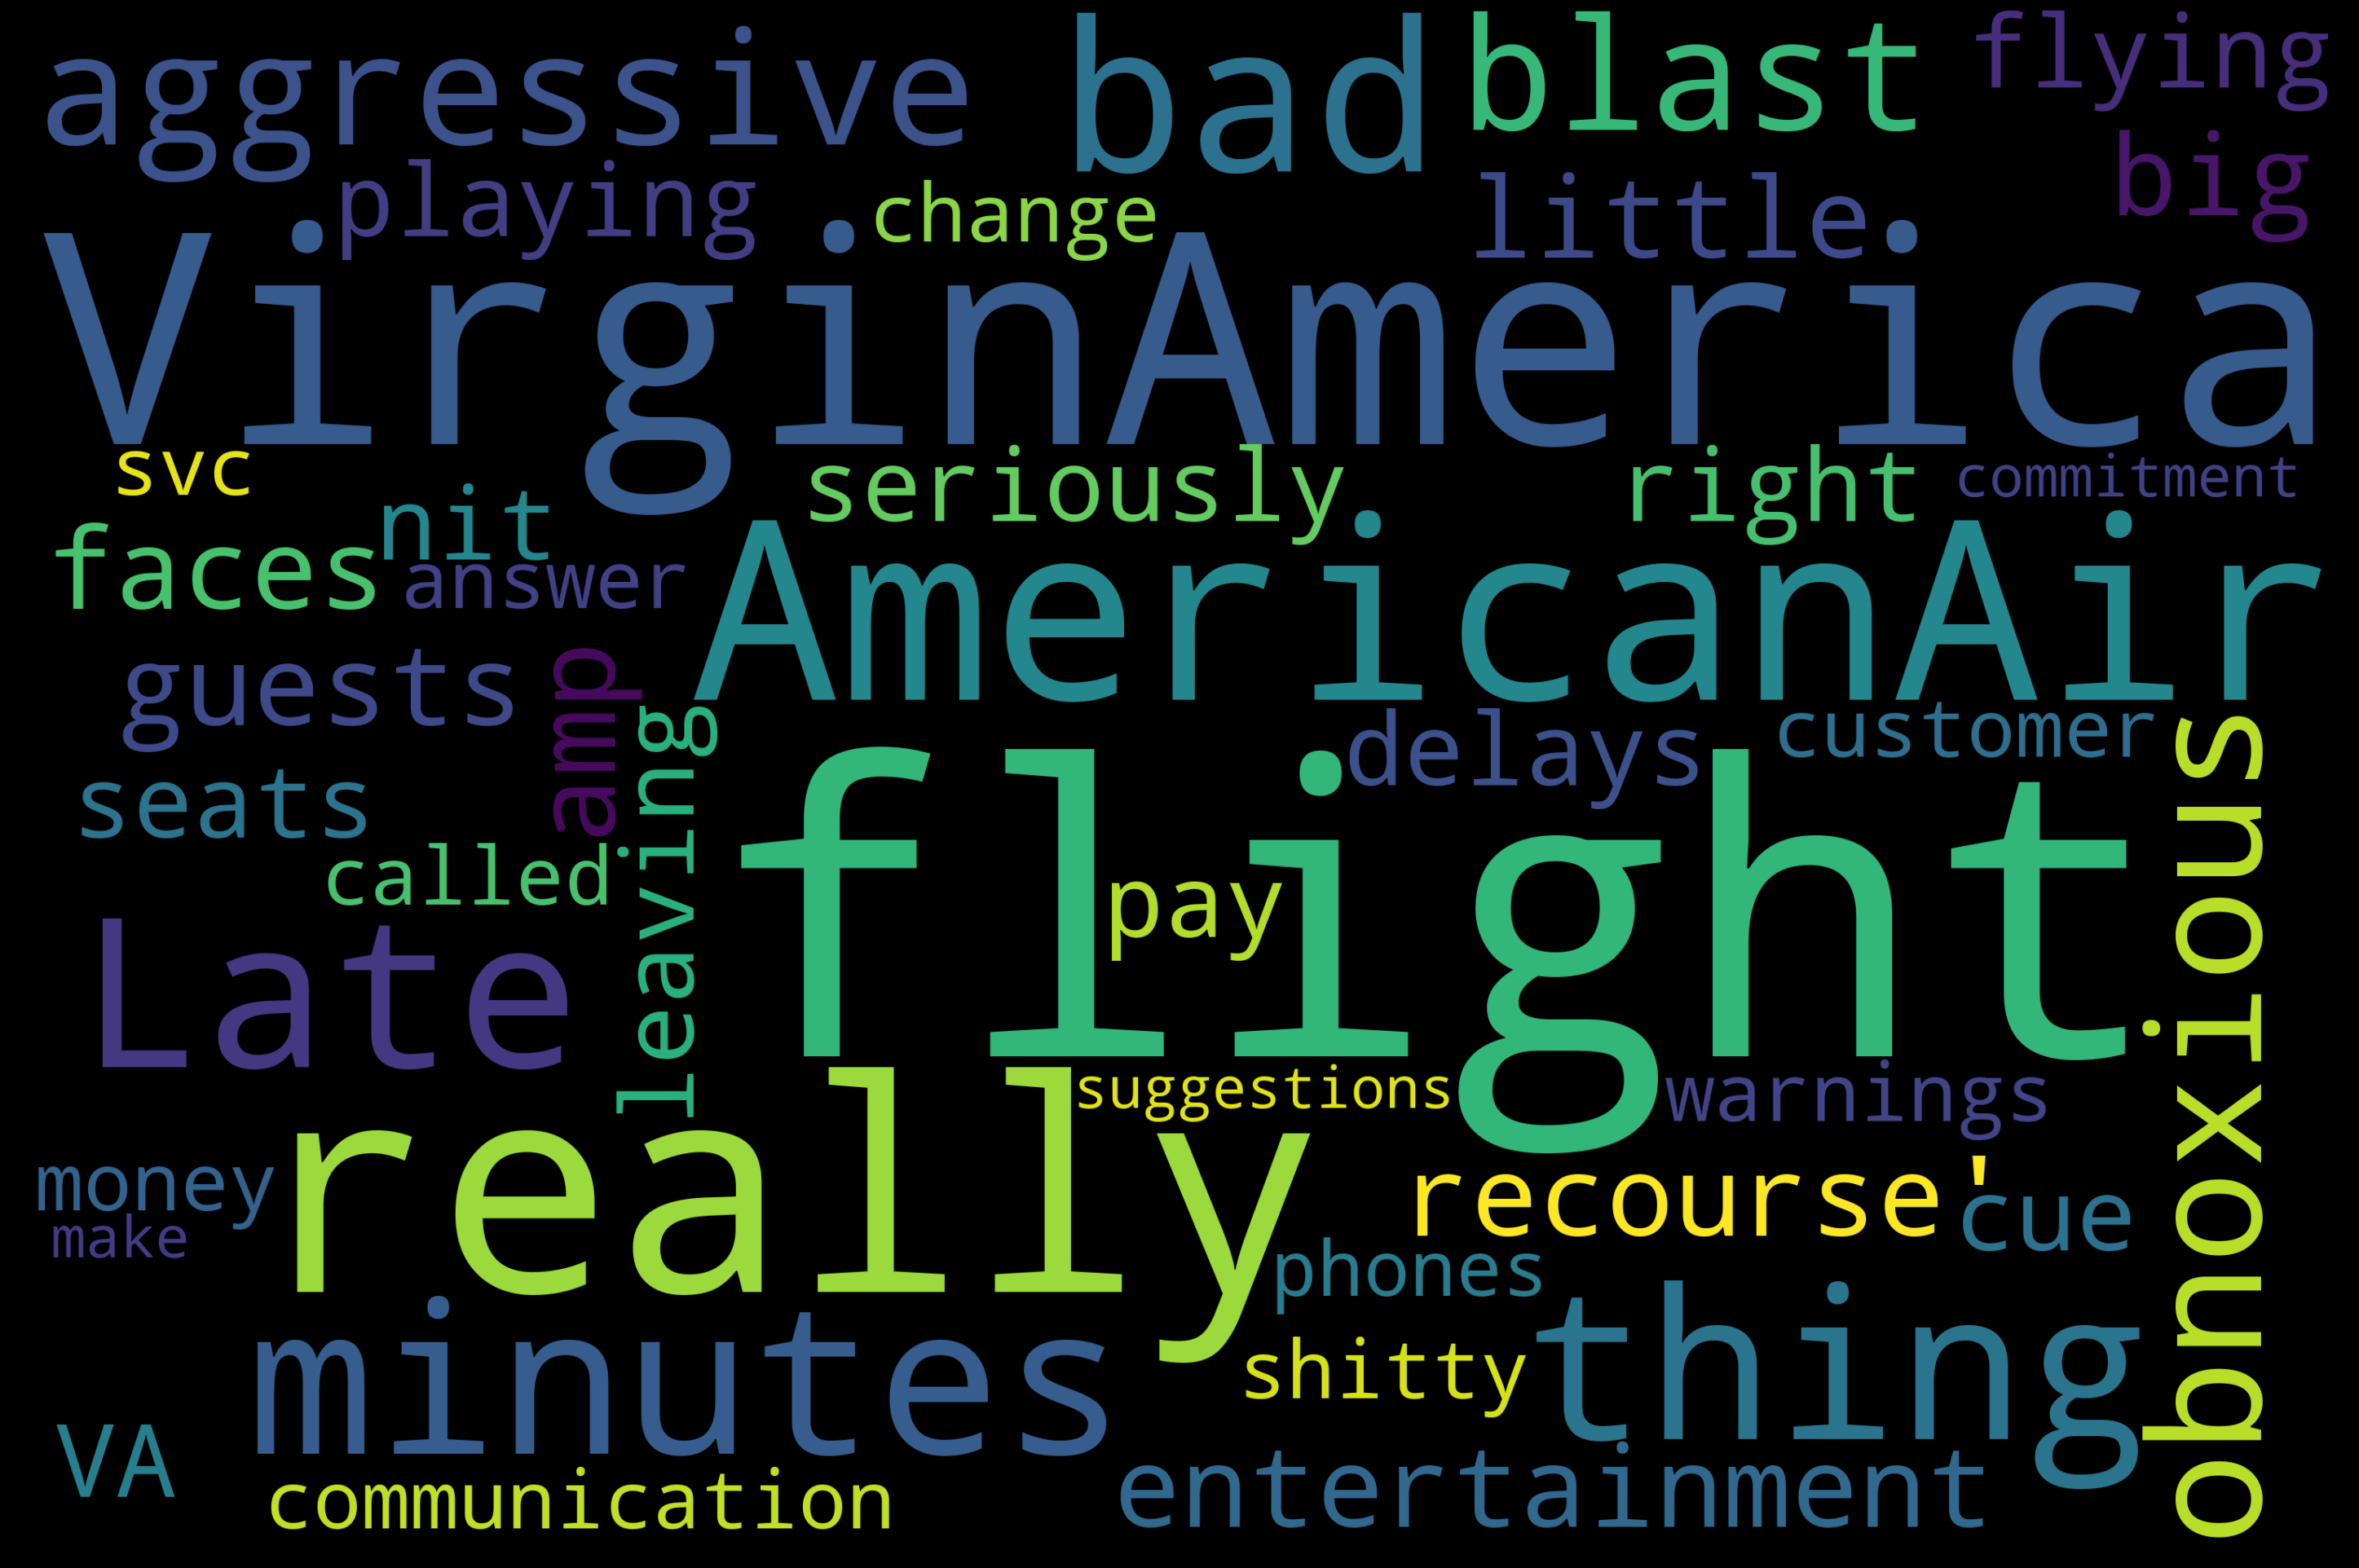

In [16]:
word_cloud(tweets_dataset.loc[tweets_dataset['airline_sentiment'] == 'negative'].text.values)

_airlines tweets shapes:_

In [17]:
American = tweets_dataset['airline'].str.contains("American")
Delta = tweets_dataset['airline'].str.contains("Delta")
Southwest = tweets_dataset['airline'].str.contains("Southwest")
United = tweets_dataset['airline'].str.contains("United")
VAmerica = tweets_dataset['airline'].str.contains("Virgin America")
USair = tweets_dataset['airline'].str.contains("US Airways")

print(f'American Tweets Shape: {American.shape}')
print(f'Delta Tweets Shape: {Delta.shape}')
print(f'Southwest Tweets Shape: {Southwest.shape}')
print(f'United Tweets Shape: {United.shape}')
print(f'VAmerica Tweets Shape: {VAmerica.shape}')
print(f'USair Tweets Shape: {USair.shape}')

American Tweets Shape: (14640,)
Delta Tweets Shape: (14640,)
Southwest Tweets Shape: (14640,)
United Tweets Shape: (14640,)
VAmerica Tweets Shape: (14640,)
USair Tweets Shape: (14640,)


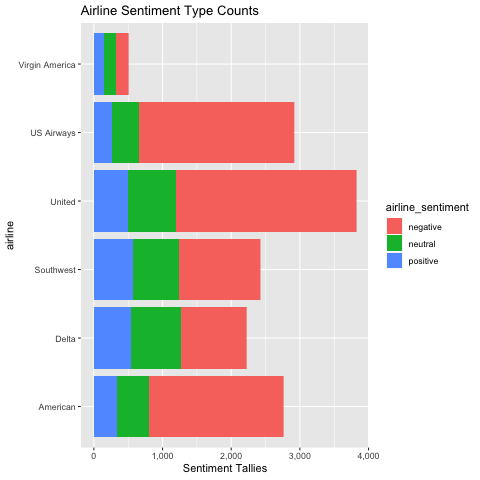

In [18]:
%%R
tweets_sentiment_groups_df <- tweets_df %>%
    group_by(airline_sentiment) %>%
    rowwise() %>%
    mutate(SENTIMENT_COUNT = n()) %>%
    select(airline, airline_sentiment, SENTIMENT_COUNT)

# tweets_sentiment_groups_df %>% head()
    
ggplot(tweets_sentiment_groups_df, aes(x = airline, y = SENTIMENT_COUNT, fill=airline_sentiment)) +
  geom_bar(stat="identity") +
  coord_flip() +
  scale_y_continuous(name="Sentiment Tallies", labels = scales::comma) +
  ggtitle("Airline Sentiment Type Counts")

**Train Test Split**

In [19]:
tweets_dataset_train, tweets_dataset_test = train_test_split(
    tweets_dataset, test_size=0.2
)

print(f'tweets_dataset_train tweets shape: {tweets_dataset_train.shape}')
print(f'tweets_dataset_test tweets shape: {tweets_dataset_test.shape}')

tweets_dataset_train tweets shape: (11712, 15)
tweets_dataset_test tweets shape: (2928, 15)


**Pre-Processing Data**

In [20]:
dataset = tweets_dataset.copy()[['airline_sentiment', 'text']]

_Dividing dataset into 3 categories by sentiment (might not be needed):_

In [21]:
positive = dataset['airline_sentiment'].str.contains("positive")
negative = dataset['airline_sentiment'].str.contains("negative")
neutral = dataset['airline_sentiment'].str.contains("neutral")

If the categories have different number of tweets the classifier could learn to guess the most prevalent category, skewing the results, so, we balance the number of tweets in each category

_We are going for 3 categories - positive, negative and neutral:_

In [22]:
dataset_positive = dataset.copy()[dataset.airline_sentiment == 'positive'][:2363]
dataset_negative = dataset.copy()[dataset.airline_sentiment == 'negative'][:2363]
dataset_neutral = dataset.copy()[dataset.airline_sentiment == 'neutral'][:2363]

dataset = pd.concat(
    [dataset_positive, dataset_negative, dataset_neutral],
    ignore_index=True
).reset_index(drop=True)

Defining a function to process tweets for analysis
Tweets contain several forms of punctuation, capitalizations, url links, etc.
They need to be cleaned prior to analysis

In [23]:
def tweet_clean(tweet):
    tweet = ''.join(c for c in tweet if c not in string. punctuation) #Removing special characters
    tweet = re.sub(r'\d+', '', tweet)  #Removing digits
    tweet = re.sub('((www\S+)|(http\S+))', '', tweet) #Removing urls
    tweet = tweet.lower().strip()  #Convering to lower case
    return tweet

_Setting up stopwords:_ Stop words are words that don’t convey any sentiment or feeling. Example: at, and, the

In [24]:
stop_words = nltk.corpus.stopwords.words("english")
stop_words = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]
stop_words = [t.encode('utf-8') for t in stop_words]

Defining a function to remove stopwords. This function splits the tweets into individual words and removes stop words

In [25]:
def remove_sw(tweet, stop_words):
    text = tweet.split()
    text = ' '.join(word for word in text if word not in stop_words)
    return text

_Processing Tweets:_

In [26]:
processed_tweets = []
for tweet in dataset['text']:
    cleaned = tweet_clean(tweet)
    stopwords_removed = remove_sw(cleaned, stop_words)
    processed_tweets.append(stopwords_removed)

dataset['text'] = processed_tweets

_Creating train and test datasets (80%-20%):_

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset['text'], dataset['airline_sentiment'], test_size=0.2
)

print(f'X_train tweets shape: {X_train.shape}')
print(f'X_test tweets shape: {X_test.shape}')
print(f'Y_train tweets shape: {Y_train.shape}')
print(f'Y_test tweets shape: {Y_test.shape}')

X_train tweets shape: (5671,)
X_test tweets shape: (1418,)
Y_train tweets shape: (5671,)
Y_test tweets shape: (1418,)


In [28]:
data_train = pd.DataFrame()
data_train['text'] = X_train
data_train['airline_sentiment'] = Y_train
data_train = data_train.reset_index(drop=True)

data_test = pd.DataFrame()
data_test['text'] = X_test
data_test['airline_sentiment'] = Y_test
data_test = data_test.reset_index(drop=True)

**Training Naive Bayes Classifier:**

In [29]:
class NaiveBayesClassifier(object):
    def __init__(self, data_train):
        self.data_train = data_train
        self.dataset_positive = data_train.copy()[data_train.airline_sentiment == 'positive']
        self.dataset_negative = data_train.copy()[data_train.airline_sentiment == 'negative']
        self.dataset_neutral = data_train.copy()[data_train.airline_sentiment == 'neutral']
    def fit(self):
        Pr_pos = dataset_positive.shape[0]/self.data_train.shape[0]
        Pr_neg = dataset_negative.shape[0]/self.data_train.shape[0]
        Pr_neu = dataset_neutral.shape[0]/self.data_train.shape[0]
        self.Prior  = (Pr_pos, Pr_neg, Pr_neu)
        self.pos_words = ' '.join(self.dataset_positive['text'].tolist()).split()
        self.neg_words = ' '.join(self.dataset_negative['text'].tolist()).split()
        self.neu_words = ' '.join(self.dataset_neutral['text'].tolist()).split()
        words_list = ' '.join(self.data_train['text'].tolist()).split()
        self.vocab = len(Counter(words_list))
        wc_pos = len(' '.join(self.dataset_positive['text'].tolist()).split())
        wc_neg = len(' '.join(self.dataset_negative['text'].tolist()).split())
        wc_neu = len(' '.join(self.dataset_neutral['text'].tolist()).split())
        self.word_count = (wc_pos, wc_neg, wc_neu)
        return self
    def predict(self, data_test):
        category = ['positive', 'negative', 'neutral']
        classification = []
        for tweet in data_test['text']:
            text = tweet.split()
            val_pos = numpy.array([])
            val_neg = numpy.array([])
            val_neu = numpy.array([])
            for word in text:
                tmp_pos = numpy.log((self.pos_words.count(word)+1)/(self.word_count[0]+self.vocab))
                tmp_neg = numpy.log((self.neg_words.count(word)+1)/(self.word_count[1]+self.vocab))
                tmp_neu = numpy.log((self.neu_words.count(word)+1)/(self.word_count[2]+self.vocab))
                val_pos = numpy.append(val_pos, tmp_pos)
                val_neg = numpy.append(val_neg, tmp_neg)
                val_neu = numpy.append(val_neu, tmp_neu)
            val_pos = numpy.log(self.Prior[0]) + numpy.sum(val_pos)
            val_neg = numpy.log(self.Prior[1]) + numpy.sum(val_neg)
            val_neu = numpy.log(self.Prior[2]) + numpy.sum(val_neu)
            probability = (val_pos, val_neg, val_neu)
            classification.append(category[numpy.argmax(probability)])
        return classification
    def score(self, feature, target):
        compare = []
        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                tmp ='correct'
                compare.append(tmp)
            else:
                tmp ='incorrect'
                compare.append(tmp)
        r = Counter(compare)
        accuracy = r['correct']/(r['correct']+r['incorrect'])
        return accuracy

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

_Running the classifier (accuracy = 78%)_

In [30]:
run = NaiveBayesClassifier(data_train)
run = run.fit()
predict = run.predict(data_test)
score = run.score(predict,data_test.airline_sentiment.tolist())
print(f'Naive Bayes Classifier Score: {score}')

Naive Bayes Classifier Score: 0.7954866008462623


_Confusion Matrix:_

[[ 0.76406534  0.16696915  0.06896552]
 [ 0.04232804  0.80952381  0.14814815]
 [ 0.02658487  0.15337423  0.8200409 ]]


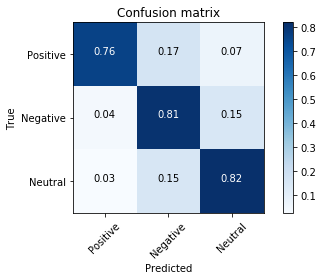

In [31]:
class_labels = ['Positive', 'Negative', 'Neutral']
cm = confusion_matrix(data_test['airline_sentiment'], predict).T
plot_confusion_matrix(cm, classes = class_labels)

_Now let's consider only 2 categories - positive and negative_

In [32]:
dataset_positive2 = dataset.copy()[dataset.airline_sentiment == 'positive'][:2363]
dataset_negative2 = dataset.copy()[dataset.airline_sentiment == 'negative'][:2363]

dataset2 = pd.concat(
    [dataset_positive2, dataset_negative2],
    ignore_index=True
).reset_index(drop=True)

Processing tweets using functions defined earlier

In [33]:
processed_tweets2 = []
for tweet in dataset2['text']:
    cleaned = tweet_clean(tweet)
    stopwords_removed = remove_sw(cleaned, stop_words)
    processed_tweets2.append(stopwords_removed)

dataset2['text'] = processed_tweets2

_Creating train and test datasets (80%-20%)_

In [34]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    dataset2['text'], dataset2['airline_sentiment'], test_size=0.2
)

print(f'X_train2 tweets shape: {X_train2.shape}')
print(f'X_test2 tweets shape: {X_test2.shape}')
print(f'Y_train2 tweets shape: {Y_train2.shape}')
print(f'Y_test2 tweets shape: {Y_test2.shape}')

X_train2 tweets shape: (3780,)
X_test2 tweets shape: (946,)
Y_train2 tweets shape: (3780,)
Y_test2 tweets shape: (946,)


In [35]:
data_train2 = pd.DataFrame()
data_train2['text'] = X_train2
data_train2['airline_sentiment'] = Y_train2
data_train2 = data_train2.reset_index(drop=True)

data_test2 = pd.DataFrame()
data_test2['text'] = X_test2
data_test2['airline_sentiment'] = Y_test2
data_test2 = data_test2.reset_index(drop=True)

_Running the classifier again (accuracy = 92%)_

In [36]:
run2 = NaiveBayesClassifier(data_train2)
run2 = run2.fit()
predict2 = run2.predict(data_test2)
score2 = run2.score(predict2,data_test2.airline_sentiment.tolist())
print(f'Naive Bayes Classifier Score2: {score2}')

Naive Bayes Classifier Score2: 0.9334038054968288


_Creating the confusion matrix_

[[ 0.9048583   0.          0.0951417 ]
 [ 0.          0.          1.        ]
 [ 0.03111111  0.          0.96888889]]


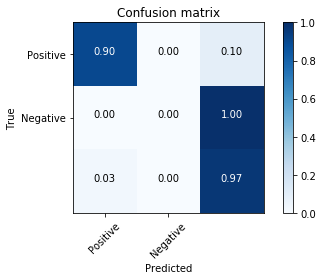

In [37]:
class_labels2 = ['Positive', 'Negative']
cm2 = confusion_matrix(data_test2['airline_sentiment'], predict2).T
plot_confusion_matrix(cm2, classes = class_labels2)

# Training Multinomial Naive Bayes

The [multinomial Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [38]:

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [39]:
def vectorize_text(text_array):
    transformer = CountVectorizer(analyzer=text_process).fit(text_array)
    vectorized_text_array = transformer.transform(text_array)
    return vectorized_text_array

In [40]:
Txt = vectorize_text(tweets_dataset['text'])

print('Shape of Sparse Matrix: ', Txt.shape)
print('Amount of Non-Zero occurrences: ', Txt.nnz)
# Percentage of non-zero values
density = (100.0 * Txt.nnz / (Txt.shape[0] * Txt.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (14640, 19717)
Amount of Non-Zero occurrences:  150578
Density: 0.05216504799747022


In [41]:
sent = tweets_dataset['airline_sentiment']

Txt_train, Txt_test, sent_train, sent_test = train_test_split(Txt, sent, test_size=0.2)

airline_sent_nb = MultinomialNB()

airline_sent_nb.fit(Txt_train, sent_train)

airline_sent_preds = airline_sent_nb.predict(Txt_test)

mat = confusion_matrix(sent_test, airline_sent_preds)
# Confusion Matrix
print(mat)
# Classification Report
print(classification_report(sent_test, airline_sent_preds))

[[1703   81   39]
 [ 347  212   53]
 [ 199   32  262]]
             precision    recall  f1-score   support

   negative       0.76      0.93      0.84      1823
    neutral       0.65      0.35      0.45       612
   positive       0.74      0.53      0.62       493

avg / total       0.73      0.74      0.72      2928



[[ 0.75722543  0.1542908   0.08848377]
 [ 0.24923077  0.65230769  0.09846154]
 [ 0.11016949  0.14971751  0.74011299]]


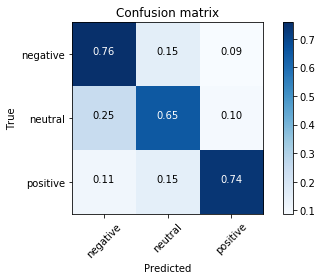

In [44]:
# Confusion Matrix Plot
plot_confusion_matrix(mat.T, classes = ['negative', 'neutral', 'positive'])

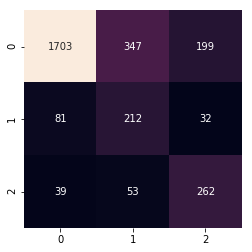

In [43]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = True, yticklabels = True)